# IDS Assignment 5 – Computer Vision

To work in this Colab notebook, first save a copy of it via "File" -> "Save a copy in Drive" in the top-left menu bar.


### 1. Install all missing packages that we need an download our custom FashionMNIST data

The data files will be available locally in your Colab runtime. You can find them through the files menu on the left.

In [ ]:
# Install packages
!pip install torchmetrics gdown

# Download training, validation, and test splits
!gdown https://drive.google.com/uc?id=1zYfBlExr_LK-Ld8rmxCTqRU5RAOUVVfh
!gdown https://drive.google.com/uc?id=1PJa_I3qG0P5whuARV_Se1_YUvHzR469R
!gdown https://drive.google.com/uc?id=1pC8-ummMGy1dPhHGPuNsms5_I7HpWgv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

### 2. Import classes and functions we will be using

In [ ]:
import math
import os
import random
from typing import Any, Callable, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.transforms import Compose, Lambda, ToTensor
from torchvision.models.resnet import ResNet, BasicBlock
from torchmetrics.functional.classification import multiclass_confusion_matrix

### 3. Check which PyTorch version we are running and confirm that we are in a GPU runtime.
If this output shows that you are not in a GPU runtime, go to "Runtime" in the top-left menu bar -> "Change runtime type" -> set "Hardware Accelerator: GPU".

In [ ]:
print(f"Running PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
!nvidia-smi

Running PyTorch version: 2.2.1+cu121
CUDA available: True
Tue Apr  2 10:31:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

### 4. Make things (more) reproducible by setting random seeds

See here for details: https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 5. Define our custom IDS FashionMNIST PyTorch dataset

Our model inherits, i.e. is a specific kind of, `VisionDataset` in torchvision.\
This means it has all features defined in `VisionDataset`, unless they are explicitly overridden here, \
plus any additional functionality that may be defined below. You can read more about `VisionDataset` here: https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html.

In [ ]:
class IDSFashionMnistDataset(VisionDataset):
    """
    FashionMNIST dataset for the IDS course which loads custom data files from disk
    """

    classes = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    def __init__(
        self,
        root: str,
        split: str = "training",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        if not split in ["training", "validation", "test"]:
            raise ValueError("Split should be 'training', 'validation', or 'test'.")

        self.split = split
        self.root = root

        self.data, self.targets = self._load_data()

    def _load_data(self):
        data = torch.load(os.path.join(self.root, f"fashion_mnist_{self.split}.pt"))
        images = data[:, :-1].reshape(-1, 28, 28)  # 28x28 resolution
        labels = data[:, -1]
        return images, labels

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

### 6. Define our custom ResNet-18 model for FashionMNIST
The original ResNet-18 uses 3-channel (RGB) inputs and has 1000 output classes based on ImageNet-1K.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

We instead use single-channel inputs (Grayscale) and 10 output classes according to FashionMNIST.

In [ ]:
class FashionMnistResNet18(ResNet):
    """
    Custom ResNet-18 model which uses 1 input channel (grayscale) and has 10 output classes
    """
    def __init__(self):
        super().__init__(BasicBlock, [2,2,2,2,2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64,
          kernel_size=(7, 7),
          stride=(2, 2),
          padding=(3, 3),
          bias=False
        )

### 7. Load our custom FashionMNIST data

Here, we load our data using the `IDSFashionMnistDataset` class defined above. We also make use of the functionality in torchvision's `VisionDataset`, which `IDSFashionMnistDataset` inherits from, to set the transformations we want to apply when retrieving examples from our dataset. We use the `transform` keyword argument for this and compose our transformations using torchvision's `Compose` (https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html). In our base setting, the only transformation we apply is `ToTensor`, which converts our `PIL.Image` inputs into PyTorch tensors.

In [ ]:
# Create base transformation for our dataset
# TODO: how can these be modified to randomly flip examples?
'''
MY WORK
'''
import torchvision.transforms as transforms
random_flip = transforms.RandomHorizontalFlip()

base_transform = Compose([
    ToTensor(),
    random_flip
])

# Load datasets
train_dataset = IDSFashionMnistDataset(".", "training", transform=base_transform)
validation_dataset = IDSFashionMnistDataset(".", "validation", transform=base_transform)
test_dataset = IDSFashionMnistDataset(".", "test", transform=base_transform)

# Check the sizes of our datasets
print(f"Training dataset length = {len(train_dataset)}")
print(f"Validation dataset length = {len(validation_dataset)}")
print(f"Test dataset length = {len(test_dataset)}")

Training dataset length = 5000
Validation dataset length = 1000
Test dataset length = 1000


### 8. Implement our evaluation function and training loop

Below, we provide some rudimentary functionality for training and evaluation,\
as well as metric storing and logging, for our experiments.

In [ ]:
def log_metrics(metrics: dict, step: Optional[int] = None):
    """
    Log metrics stored in a dictionary
    """

    # During training, it can be useful to also log the current step
    if step is not None:
        print(f"\nMetrics step {step}:")

    for k, v in metrics.items():
        # We ignore the confusion matrix when logging metrics
        if not k.endswith("conf_matrix"):
            print(f"  {k}: {v}")

def evaluate(model, eval_dataloader, prefix="eval"):
    """
    Evaluation function that computes the loss, accuracy, and confusion matrix for the dataset
    passed via the `eval_dataloader` argument
    """

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    # Set model to evaluation mode (e.g. to disable dropout)
    model.eval()

    eval_loss = 0
    y_pred = None
    y_true = None
    num_classes = None

    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating")):
        # Loop over batches in dataloader
        '''
        ISN'T IT ALREADY DOING THIS?
        '''

        # Move batch to GPU
        inputs, labels = batch
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Use no_grad mode to disable gradient computation
        with torch.no_grad():
            # Get model outputs
            outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        eval_loss += loss.detach().cpu().item()

        if num_classes is None:
            num_classes = len(outputs[0])

        # Get class predictions
        preds = torch.argmax(outputs, dim=-1)

        # Accumulate predictions and true classes over batches
        y_pred = torch.cat([y_pred, preds]) if y_pred is not None else preds
        y_true = torch.cat([y_true, labels]) if y_true is not None else labels


    # Move predictions and true classes back to CPU
    y_pred = y_pred.detach().cpu()
    y_true = y_true.detach().cpu()

    # Compute metrics
    eval_loss /= len(eval_dataloader)
    eval_acc = (y_pred == y_true).sum() / len(y_true)
    eval_conf_matrix = multiclass_confusion_matrix(
        y_pred, y_true, num_classes=num_classes
    )

    # Store metrics in a dictionary
    metrics = {
        f"{prefix}_loss": eval_loss,
        f"{prefix}_accuracy": eval_acc.item(),
        f"{prefix}_conf_matrix": eval_conf_matrix.numpy()
    }

    return metrics


def save_best_model(model: nn.Module):
  """
  Simple function that saves the weights of the specified model to disk.
  We use this to keep track of the best model (based on validation loss).
  """
  output_path = "best_model.pt"
  torch.save(model.state_dict(), output_path)
  print(f"Saved new best model to {output_path}\n")


def load_best_model(model: nn.Module, model_path: str = "best_model.pt"):
  """
  Simple function that loads model weights stored at `model_path` into the
  passed model of type `nn.Module`. We use this to load our best model checkpoint.
  """
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"Loaded best {model.__class__.__name__} model from {model_path}\n")
  return model


def train(
  model: nn.Module,
  train_dataloader: DataLoader,
  eval_dataloader: DataLoader,
  num_epochs: int = 20,
  lr: float = 0.1,
  eval_steps: int = 100
):
    """
    Training loop
    """

    # Create SGD optimizer with specified learning rate and fixed momentum
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

    # Create linear learning rate decay schedule
    scheduler = LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=1e-6,
        total_iters=len(train_dataloader) * num_epochs
    )

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    total_loss = 0
    total_eval_loss = 0
    global_step = 0
    global_eval_step = 0
    best_eval_loss = float("inf")

    # Store our initial model
    save_best_model(model)

    # Create dictionary to store metrics throughout training
    metrics_dict = {}

    print("Starting model training")

    for epoch_idx in range(num_epochs):
        # Epoch loop (one epoch is one pass over the full training dataset)

        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_idx+1}")):
            # Loop over batches in training dataset

            # Set model to training mode
            model.train()

            global_step += 1

            # Move batch to GPU
            inputs, labels = batch
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Get model outputs
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.detach().cpu().item()

            # Evaluation loop
            if global_step % eval_steps == 0:
                global_eval_step += 1
                metrics = {
                    "mean_train_loss": total_loss / global_step,
                    "learning_rate": scheduler.get_last_lr()[0]
                }

                # Evaluate on validation and training datasets
                metrics.update(evaluate(model, eval_dataloader, prefix="eval"))
                metrics.update(evaluate(model, train_dataloader, prefix="train"))

                # Update and log metrics
                total_eval_loss += metrics["eval_loss"]
                metrics["mean_eval_loss"] = total_eval_loss / global_eval_step
                log_metrics(metrics, step=global_step)
                metrics_dict[global_step] = metrics

                # Check if our validation loss has decreased, and if so,
                # update our best model checkpoint
                if metrics["eval_loss"] <= best_eval_loss:
                  best_eval_loss = metrics["eval_loss"]
                  save_best_model(model)

            # Compute gradients
            loss.backward()

            # Perform update step
            optimizer.step()

            # Reduce learning rate for stability
            scheduler.step()

            # Set gradients to zero
            model.zero_grad()

    return metrics_dict

### 9. Define hyperparameters, create dataloaders, instantiate model, and run training/evaluation procedure

Here, we set our hyper-parameters for the dataloader (batch size) and the training loop \
(number of epochs, learning rate, and evaluation interval in steps).

We only use very basic data loading functionality. More information on available features can be found here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [ ]:
# TODO: set your hyperparameters
bs = 256
num_epochs = 100
lr = 0.1
eval_steps = 100

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# Instantiate a new model
model = FashionMnistResNet18()

# Train model and save training and evaluation metrics
metrics_dict = train(
    model, train_dataloader, validation_dataloader, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s]

Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]



Metrics step 100:
  mean_train_loss: 0.817957621216774
  learning_rate: 0.09505000494999999
  eval_loss: 0.5853217244148254
  eval_accuracy: 0.7900000214576721
  train_loss: 0.49934637248516084
  train_accuracy: 0.8176000118255615
  mean_eval_loss: 0.5853217244148254
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.63it/s]

Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]



Metrics step 200:
  mean_train_loss: 0.6067972983419895
  learning_rate: 0.09005000994999993
  eval_loss: 0.4526776969432831
  eval_accuracy: 0.8399999737739563
  train_loss: 0.3105908311903477
  train_accuracy: 0.8841999769210815
  mean_eval_loss: 0.5189997106790543
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.30it/s]

Epoch 15: 100%|██████████| 20/20 [00:02<00:00,  6.76it/s]



Metrics step 300:
  mean_train_loss: 0.4929655644794305
  learning_rate: 0.08505001494999989
  eval_loss: 0.4564211815595627
  eval_accuracy: 0.8690000176429749
  train_loss: 0.19824645295739174
  train_accuracy: 0.9297999739646912
  mean_eval_loss: 0.49814020097255707


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.21it/s]

Epoch 20: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]



Metrics step 400:
  mean_train_loss: 0.4188504304550588
  learning_rate: 0.08005001994999977
  eval_loss: 0.5459248200058937
  eval_accuracy: 0.8450000286102295
  train_loss: 0.2089999496936798
  train_accuracy: 0.9261999726295471
  mean_eval_loss: 0.5100863557308912


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.00it/s]

Epoch 25: 100%|██████████| 20/20 [00:02<00:00,  7.07it/s]



Metrics step 500:
  mean_train_loss: 0.361692712508142
  learning_rate: 0.07505002494999956
  eval_loss: 0.5424046292901039
  eval_accuracy: 0.8479999899864197
  train_loss: 0.09750993065536022
  train_accuracy: 0.9656000137329102
  mean_eval_loss: 0.5165500104427337


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.54it/s]

Epoch 30: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]



Metrics step 600:
  mean_train_loss: 0.3172307977452874
  learning_rate: 0.07005002994999944
  eval_loss: 0.7223052233457565
  eval_accuracy: 0.8270000219345093
  train_loss: 0.10029118470847606
  train_accuracy: 0.9631999731063843
  mean_eval_loss: 0.5508425459265709


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.25it/s]

Epoch 35: 100%|██████████| 20/20 [00:02<00:00,  7.92it/s]



Metrics step 700:
  mean_train_loss: 0.2838453733761396
  learning_rate: 0.06505003494999935
  eval_loss: 0.6352131143212318
  eval_accuracy: 0.8659999966621399
  train_loss: 0.07548909392207862
  train_accuracy: 0.9733999967575073
  mean_eval_loss: 0.5628954842686653


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s]

Epoch 40: 100%|██████████| 20/20 [00:02<00:00,  6.70it/s]



Metrics step 800:
  mean_train_loss: 0.25460313395480627
  learning_rate: 0.06005003994999934
  eval_loss: 0.7249339520931244
  eval_accuracy: 0.8500000238418579
  train_loss: 0.05205311980098486
  train_accuracy: 0.9811999797821045
  mean_eval_loss: 0.5831502927467227


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.24it/s]

Epoch 45: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]



Metrics step 900:
  mean_train_loss: 0.22960300540758505
  learning_rate: 0.055050044949999356
  eval_loss: 0.8099561780691147
  eval_accuracy: 0.8460000157356262
  train_loss: 0.01837525104638189
  train_accuracy: 0.9940000176429749
  mean_eval_loss: 0.608350946671433


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.40it/s]

Epoch 50: 100%|██████████| 20/20 [00:02<00:00,  7.79it/s]



Metrics step 1000:
  mean_train_loss: 0.2081882309759967
  learning_rate: 0.050050049949999446
  eval_loss: 0.8237190693616867
  eval_accuracy: 0.8529999852180481
  train_loss: 0.005708173126913607
  train_accuracy: 0.998199999332428
  mean_eval_loss: 0.6298877589404583


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.07it/s]

Epoch 55: 100%|██████████| 20/20 [00:02<00:00,  7.32it/s]



Metrics step 1100:
  mean_train_loss: 0.1898111292841548
  learning_rate: 0.045050054949999536
  eval_loss: 0.9293132871389389
  eval_accuracy: 0.8510000109672546
  train_loss: 0.0018122342618880794
  train_accuracy: 0.9998000264167786
  mean_eval_loss: 0.6571082615039565


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.23it/s]

Epoch 60: 100%|██████████| 20/20 [00:02<00:00,  7.00it/s]



Metrics step 1200:
  mean_train_loss: 0.17453832957393994
  learning_rate: 0.04005005994999966
  eval_loss: 1.0096174627542496
  eval_accuracy: 0.8529999852180481
  train_loss: 0.004157658293843269
  train_accuracy: 0.9986000061035156
  mean_eval_loss: 0.6864840282748143


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.53it/s]

Epoch 65: 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]



Metrics step 1300:
  mean_train_loss: 0.16138410570415615
  learning_rate: 0.03505006494999977
  eval_loss: 0.9183312207460403
  eval_accuracy: 0.8579999804496765
  train_loss: 0.0006369118069414981
  train_accuracy: 1.0
  mean_eval_loss: 0.7043184276956779


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.07it/s]

Epoch 70: 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]



Metrics step 1400:
  mean_train_loss: 0.14989407556040013
  learning_rate: 0.030050069949999845
  eval_loss: 0.9492327570915222
  eval_accuracy: 0.8650000095367432
  train_loss: 0.00021180329022172373
  train_accuracy: 1.0
  mean_eval_loss: 0.7218123083668095


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 20.94it/s]

Epoch 75: 100%|██████████| 20/20 [00:02<00:00,  7.25it/s]



Metrics step 1500:
  mean_train_loss: 0.13992402518901995
  learning_rate: 0.025050074949999862
  eval_loss: 0.9840435534715652
  eval_accuracy: 0.8529999852180481
  train_loss: 0.0001631065835681511
  train_accuracy: 1.0
  mean_eval_loss: 0.7392943913737933


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.03it/s]

Epoch 80: 100%|██████████| 20/20 [00:03<00:00,  6.66it/s]



Metrics step 1600:
  mean_train_loss: 0.13119481094592175
  learning_rate: 0.02005007994999987
  eval_loss: 1.0590737015008926
  eval_accuracy: 0.8519999980926514
  train_loss: 0.00012448428715288172
  train_accuracy: 1.0
  mean_eval_loss: 0.759280598256737


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.17it/s]

Epoch 85: 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]



Metrics step 1700:
  mean_train_loss: 0.12349127706398362
  learning_rate: 0.015050084949999864
  eval_loss: 1.024278163909912
  eval_accuracy: 0.8529999852180481
  train_loss: 0.00011189509023097343
  train_accuracy: 1.0
  mean_eval_loss: 0.7748686903539825


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.81it/s]

Epoch 90: 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]



Metrics step 1800:
  mean_train_loss: 0.11664657672472256
  learning_rate: 0.010050089949999917
  eval_loss: 1.0547404438257217
  eval_accuracy: 0.8519999980926514
  train_loss: 0.00012184155220893445
  train_accuracy: 1.0
  mean_eval_loss: 0.7904171211024126


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.05it/s]

Epoch 95: 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]



Metrics step 1900:
  mean_train_loss: 0.11052154494250747
  learning_rate: 0.005050094949999962
  eval_loss: 1.0420907586812973
  eval_accuracy: 0.8529999852180481
  train_loss: 9.893623719108291e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.803663102027617


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.17it/s]

Epoch 100: 100%|██████████| 20/20 [00:02<00:00,  6.97it/s]


Metrics step 2000:
  mean_train_loss: 0.1050060179176362
  learning_rate: 5.009994999999962e-05
  eval_loss: 1.051689401268959
  eval_accuracy: 0.8629999756813049
  train_loss: 9.803882239793893e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8160644169896841


### 10. Load our saved best model checkpoint

We can make use of the `load_best_model` function defined above to quickly load \
the best model checkpoint for further evaluation.

You can find more information on saving and loading model weights at

https://pytorch.org/tutorials/beginner/saving_loading_models.html.

In [ ]:
best_model = load_best_model(FashionMnistResNet18())

Loaded best FashionMnistResNet18 model from best_model.pt



### 11. Evaluate your best model and visualize the confusion matrix

TODO: You should implement this yourself using the functions defined above.

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 16.42it/s]


Text(0.5, 1.0, 'Confusion Matrix of Test Dataset')

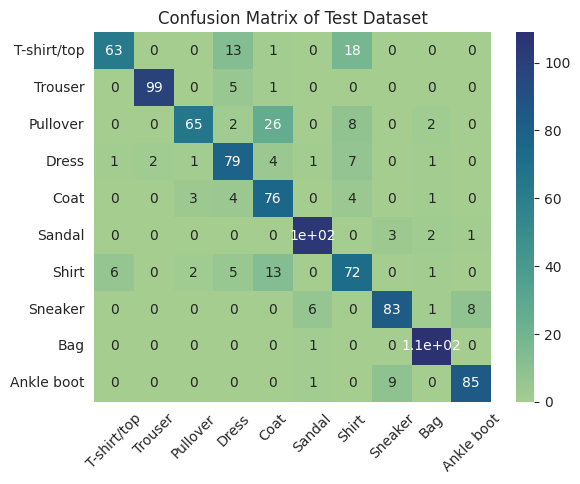

In [ ]:
# TODO
eval = evaluate(
    model = best_model,
    eval_dataloader = test_dataloader
)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
sns.heatmap(
    data = eval.get('eval_conf_matrix'),
    xticklabels=classes,
    yticklabels=classes,
    cmap = 'crest',
    annot = True
)
plt.xticks(rotation=45)
plt.title("Confusion Matrix of Test Dataset")

In [ ]:
print("Test accuracy at the best validation loss")
eval.get("eval_accuracy")

Test accuracy at the best validation loss


0.8360000252723694

### 12. Plot your loss curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

In [ ]:
metrics_dict.get(100)

{'mean_train_loss': 0.817957621216774,
 'learning_rate': 0.09505000494999999,
 'eval_loss': 0.5853217244148254,
 'eval_accuracy': 0.7900000214576721,
 'eval_conf_matrix': array([[ 61,   0,   0,  21,   0,   0,   3,   0,   1,   0],
        [  0, 102,   0,   3,   1,   0,   0,   0,   0,   0],
        [  3,   0,  66,   5,  25,   0,  14,   0,   1,   0],
        [  0,   0,   0,  92,   3,   0,   0,   0,   0,   0],
        [  0,   1,   1,   9,  74,   0,   5,   0,   1,   0],
        [  0,   0,   0,   1,   0,  74,   0,  11,   6,   1],
        [ 18,   0,  11,  19,  17,   0,  26,   0,   2,   0],
        [  0,   0,   0,   0,   0,   3,   0,  88,   0,   9],
        [  0,   0,   0,   2,   1,   0,   0,   2, 106,   0],
        [  0,   0,   0,   0,   0,   2,   0,   8,   0, 101]]),
 'train_loss': 0.49934637248516084,
 'train_accuracy': 0.8176000118255615,
 'train_conf_matrix': array([[360,   0,   3, 133,   0,   0,  19,   0,   5,   0],
        [  0, 441,   0,  13,   1,   0,   0,   0,   1,   0],
        [  4

Text(0, 0.5, 'Loss')

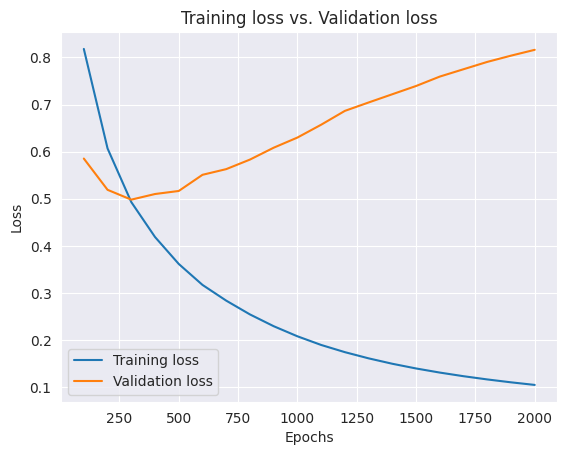

In [ ]:
# TODO
# Retrieving relevant data
reported_epochs = list(metrics_dict.keys())
training_losses = [metrics_dict.get(epoch).get("mean_train_loss") for epoch in reported_epochs]
validation_losses = [metrics_dict.get(epoch).get("mean_eval_loss") for epoch in reported_epochs]

# Plotting
sns.set_style("darkgrid")
sns.lineplot(x=reported_epochs, y=training_losses, label="Training loss")
#sns.scatterplot(x=reported_epochs, y=training_losses)
sns.lineplot(x=reported_epochs, y=validation_losses, label="Validation loss")
#sns.scatterplot(x=reported_epochs, y=validation_losses)
plt.title("Training loss vs. Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

### 12. Plot your accuracy curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

Text(0, 0.5, 'Accuracy')

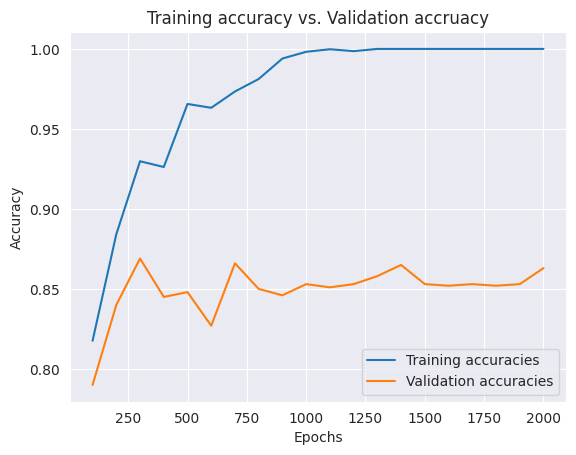

In [ ]:
# TODO
# Retrieving relevant data
reported_epochs = metrics_dict.keys()
training_accuracies = [metrics_dict.get(epoch).get("train_accuracy") for epoch in reported_epochs]
validation_accuracies = [metrics_dict.get(epoch).get("eval_accuracy") for epoch in reported_epochs]

# Plotting
sns.set_style("darkgrid")
sns.lineplot(x=reported_epochs, y=training_accuracies, label="Training accuracies")
#sns.scatterplot(x=reported_epochs, y=training_accuracies)
sns.lineplot(x=reported_epochs, y=validation_accuracies, label="Validation accuracies")
#sns.scatterplot(x=reported_epochs, y=validation_accuracies)
plt.title("Training accuracy vs. Validation accruacy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")


In [ ]:
best_validation_loss_idx = np.argmin(validation_losses)
best_validation_loss_idx

2